Team Gordon

Student Name	Student Number
 Alisha Sahota	20497348
 Anthony Ramelo	20499391
 Chris Wu	10182394
 Elizabeth Zhang	20161231
 Emily Zhao	10096273
 Sam Hossain	20466500


Missing Values in Engagement Data:
loanid                        0
id-date                       0
month                         0
quiz_answer_count             0
mood_answer_count             0
inspiration_answer_count      0
self_assessment_count         0
activities_count              0
wellness_score              216
dtype: int64

Missing Values in Goals Data:
id                                     0
public_id                              0
assessment_completed_date              0
assessment_month                       0
month_being_assessed                   0
goal_no_new_debt                       0
goal_paid_bills_on_time                0
goal_paid_parachute_on_time            4
reason                              1762
under_utilization                      0
user_id                                0
admin_notes                         1873
plan_date1                          1571
plan_apply_savings_to_cc            1571
plan_auto_withdrawal                1571
plan_chat_before_n

/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_86724/589525343.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  goals_data.fillna(0, inplace=True)


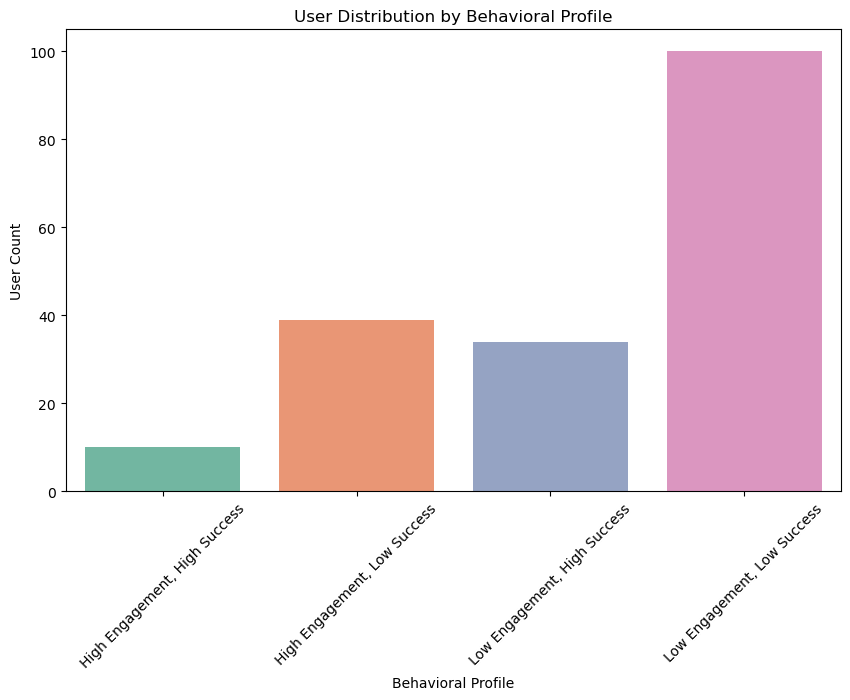

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the relevant sheets
engagement_sheet = 'Monthly Wellness and Engagement'
goals_sheet = 'Goals_and_plans_ALLDATA_202410'

# Load the datasets
engagement_data = pd.read_excel(file_path, sheet_name=engagement_sheet)
goals_data = pd.read_excel(file_path, sheet_name=goals_sheet)

# Add a prefix to public_id in goals data to match potential loanid format
goals_data['public_id'] = '1' + goals_data['public_id'].astype(str)

# Step 1: Missing Value Analysis and Data Cleaning
print("Missing Values in Engagement Data:")
print(engagement_data.isnull().sum())
print("\nMissing Values in Goals Data:")
print(goals_data.isnull().sum())

# Handle missing values (example: filling with 0 or forward fill, depending on the column's nature)
engagement_data.fillna(0, inplace=True)  # Replace 0 with appropriate handling logic
goals_data.fillna(0, inplace=True)

# Step 2: Aggregate Engagement Data
engagement_summary = engagement_data.groupby('loanid').agg(
    total_quizzes=('quiz_answer_count', 'sum'),
    total_mood_activities=('mood_answer_count', 'sum'),
    total_inspiration_activities=('inspiration_answer_count', 'sum'),
    total_self_assessments=('self_assessment_count', 'sum'),
    total_activities=('activities_count', 'sum'),
    average_activities_per_month=('activities_count', 'mean')
).reset_index()

# Step 3: Compute Goal Completion Metrics
goal_completion_summary = goals_data.groupby('public_id').agg(
    total_goals=('goal_no_new_debt', 'count'),
    goals_no_new_debt=('goal_no_new_debt', 'sum'),
    goals_paid_bills_on_time=('goal_paid_bills_on_time', 'sum'),
    goal_paid_parachute_on_time=('goal_paid_parachute_on_time', 'sum'),
    goals_under_utilization=('under_utilization', 'sum')
).reset_index()

# Add individual goal success rates
goal_completion_summary['no_new_debt_success_rate'] = (
    goal_completion_summary['goals_no_new_debt'] / goal_completion_summary['total_goals']
)
goal_completion_summary['paid_bills_success_rate'] = (
    goal_completion_summary['goals_paid_bills_on_time'] / goal_completion_summary['total_goals']
)
goal_completion_summary['parachute_success_rate'] = (
    goal_completion_summary['goal_paid_parachute_on_time'] / goal_completion_summary['total_goals']
)
goal_completion_summary['under_utilization_success_rate'] = (
    goal_completion_summary['goals_under_utilization'] / goal_completion_summary['total_goals']
)

# Add weighted success rate
weights = {
    'goals_no_new_debt': 0.4,
    'goals_paid_bills_on_time': 0.3,
    'goal_paid_parachute_on_time': 0.2,
    'goals_under_utilization': 0.1
}
goal_completion_summary['weighted_goal_success_rate'] = goal_completion_summary.apply(
    lambda x: (
        weights['goals_no_new_debt'] * x['goals_no_new_debt'] +
        weights['goals_paid_bills_on_time'] * x['goals_paid_bills_on_time'] +
        weights['goal_paid_parachute_on_time'] * x['goal_paid_parachute_on_time'] +
        weights['goals_under_utilization'] * x['goals_under_utilization']
    ) / x['total_goals'] if x['total_goals'] > 0 else 0,
    axis=1
)

# Ensure loanid and public_id are strings for merging
engagement_summary['loanid'] = engagement_summary['loanid'].astype(str)
goal_completion_summary['public_id'] = goal_completion_summary['public_id'].astype(str)

# Step 4: Time-Based Analysis
if 'date' in engagement_data.columns:
    engagement_data['date'] = pd.to_datetime(engagement_data['date'])
    engagement_trends = engagement_data.groupby(engagement_data['date'].dt.to_period('M')).sum()

    plt.figure(figsize=(12, 6))
    engagement_trends['activities_count'].plot(kind='line', marker='o', title='Monthly Engagement Activities')
    plt.xlabel('Month')
    plt.ylabel('Total Activities')
    plt.show()

    # Rolling average for seasonal patterns
    engagement_trends['rolling_avg'] = engagement_trends['activities_count'].rolling(window=3).mean()
    engagement_trends[['activities_count', 'rolling_avg']].plot(figsize=(12, 6), title='Rolling Average of Activities')
    plt.xlabel('Month')
    plt.ylabel('Activities')
    plt.show()

if 'date' in goals_data.columns:
    goals_data['date'] = pd.to_datetime(goals_data['date'])
    goal_trends = goals_data.groupby(goals_data['date'].dt.to_period('M')).mean()

    plt.figure(figsize=(12, 6))
    goal_trends['weighted_goal_success_rate'].plot(kind='line', marker='o', title='Monthly Goal Success Rate')
    plt.xlabel('Month')
    plt.ylabel('Average Success Rate')
    plt.show()

# Step 5: Feature Engineering - Engagement-to-Success Ratio
goal_completion_summary['engagement_to_success_ratio'] = (
    engagement_summary['average_activities_per_month'] / goal_completion_summary['weighted_goal_success_rate']
)
goal_completion_summary['engagement_to_success_ratio'].fillna(0, inplace=True)  # Handle division by zero

# Step 6: Categorical Analysis (if categorical columns exist)
if 'demographic_group' in engagement_data.columns:
    demographic_analysis = engagement_data.groupby('demographic_group').mean()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=demographic_analysis, x=demographic_analysis.index, y='activities_count', palette='coolwarm')
    plt.title('Engagement by Demographic Group')
    plt.xlabel('Demographic Group')
    plt.ylabel('Average Activities')
    plt.show()

# Step 7: Behavioral Profiles
high_engagement_threshold = engagement_summary['average_activities_per_month'].quantile(0.75)
high_success_threshold = goal_completion_summary['weighted_goal_success_rate'].quantile(0.75)

engagement_summary['engagement_category'] = engagement_summary['average_activities_per_month'].apply(
    lambda x: 'High' if x >= high_engagement_threshold else 'Low'
)
goal_completion_summary['success_category'] = goal_completion_summary['weighted_goal_success_rate'].apply(
    lambda x: 'High' if x >= high_success_threshold else 'Low'
)

profiles = pd.merge(
    engagement_summary[['loanid', 'engagement_category']],
    goal_completion_summary[['public_id', 'success_category']],
    left_on='loanid',
    right_on='public_id',
    how='inner'
)
profiles['behavioral_profile'] = profiles.apply(
    lambda row: f"{row['engagement_category']} Engagement, {row['success_category']} Success", axis=1
)

# Step 8: Visualize Behavioral Profile Distribution
profile_summary = profiles.groupby('behavioral_profile').size().reset_index(name='user_count')

plt.figure(figsize=(10, 6))
sns.barplot(data=profile_summary, x='behavioral_profile', y='user_count', palette='Set2')
plt.title('User Distribution by Behavioral Profile')
plt.xlabel('Behavioral Profile')
plt.ylabel('User Count')
plt.xticks(rotation=45)
plt.show()